In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from itertools import product

In [2]:
def activation(x: torch.Tensor, function: str) -> torch.Tensor:
    if function == 'relu':
        return torch.where(x > 0, x, torch.zeros_like(x))
    elif function == 'sigmoid':
        return 1 / (1 + torch.exp(-x))
    elif function == 'tanh':
        return torch.tanh(x)
    elif function == 'linear':
        return x
    else:
        raise ValueError(f"Activation function {function} not supported")

In [3]:
def act_der(x: torch.Tensor, function: str) -> torch.Tensor:
    if function == 'relu':
        return (x > 0).float()
    elif function == 'sigmoid':
        sig = activation(x, 'sigmoid')
        return sig * (1 - sig)
    elif function == 'tanh':
        return 1 - activation(x, 'tanh').pow(2)
    elif function == 'linear':
        return torch.ones_like(x)
    else:
        raise ValueError(f"Activation function {function} not supported")

In [4]:
def loss(gt: torch.Tensor, pred: torch.Tensor, function: str) -> torch.Tensor:
    if gt.device != pred.device:
        gt = gt.to(pred.device)
        
    if function == 'mse':
        return torch.mean((pred - gt).pow(2))
    elif function == 'bce':
        return -torch.mean(gt * torch.log(pred + 1e-7) + (1 - gt) * torch.log(1 - pred + 1e-7))


In [5]:
def loss_der(gt: torch.Tensor, pred: torch.Tensor, function: str) -> torch.Tensor:
    if gt.device != pred.device:
        gt = gt.to(pred.device)
        
    if function == 'mse':
        return 2 * (pred - gt) / gt.size(1)
    elif function == 'bce':
        return -gt / (pred + 1e-7) + (1 - gt) / (1 - pred + 1e-7)

In [6]:
class NeuralNetwork:
    def __init__(self, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.layers = []
        self.z_list = []
        self.a_list = []
        self.device = device

    def add_layer(self, input_size: int, output_size: int, activation: str):
        # Initialize weights using He initialization for ReLU or Xavier for sigmoid/tanh
        if activation == 'relu':
            w = torch.randn(output_size, input_size, device=self.device) * torch.sqrt(torch.tensor(2.0 / input_size, device=self.device))
        else:
            w = torch.randn(output_size, input_size, device=self.device) * torch.sqrt(torch.tensor(1.0 / input_size, device=self.device))
            
        b = torch.zeros(output_size, 1, device=self.device)
        self.layers.append([w, b, activation])
        self.z_list.append(None)
        self.a_list.append(None)

    def forwardprop(self, x: torch.Tensor) -> torch.Tensor:
        current_input = x.to(self.device)  
        for i in range(len(self.layers)):
            w, b, activation_func = self.layers[i]
            z = torch.mm(w, current_input) + b
            self.z_list[i] = z
            self.a_list[i] = activation(z, activation_func)
            current_input = self.a_list[i]
        return self.a_list[-1]

    def backprop(self, x: torch.Tensor, y: torch.Tensor, loss_function: str, learning_rate: float = 0.01):
        m = x.size(1)  
        self.forwardprop(x)
        
        dz = loss_der(y, self.a_list[-1], loss_function)
        for i in range(len(self.layers)-1, -1, -1):
            w, b, activation_func = self.layers[i]
            a_prev = self.a_list[i-1] if i > 0 else x
            
            dz = dz * act_der(self.z_list[i], activation_func)
            dw = (1/m) * torch.mm(dz, a_prev.T)
            db = (1/m) * torch.sum(dz, dim=1, keepdim=True)
            
            self.layers[i][0] = w - learning_rate * dw
            self.layers[i][1] = b - learning_rate * db
            
            if i > 0:
                dz = torch.mm(w.T, dz)

    def train(self, X: torch.Tensor, y: torch.Tensor, epochs: int = 100, 
             batch_size: int = 32, learning_rate: float = 0.01, 
             loss_function: str = 'mse', optimizer: str = 'Mini_Batch', verbose: bool = True):
        n_samples = X.size(1)  
        
        X = X.to(self.device)  # Move X to the correct device
        y = y.to(self.device)  # Move y to the correct device
        
        epoch_losses = []

        for epoch in range(epochs):
            total_loss = 0.0
            perm = torch.randperm(n_samples, device=self.device)
            X_shuffled = X[:, perm]
            y_shuffled = y[:, perm]  
            
            if optimizer == 'Batch':
                # Process all samples at once
                pred = self.forwardprop(X_shuffled)
                batch_loss = loss(y_shuffled, pred, loss_function)
                total_loss += batch_loss.item()
                self.backprop(X_shuffled, y_shuffled, loss_function, learning_rate)
            
            elif optimizer == 'SGD':
                # Stochastic Gradient Descent - process one sample at a time
                for i in range(n_samples):
                    X_sample = X_shuffled[:, i:i+1]  # Get a single sample
                    y_sample = y_shuffled[:, i:i+1]  # Get corresponding label
                    
                    pred = self.forwardprop(X_sample)
                    sample_loss = loss(y_sample, pred, loss_function)
                    total_loss += sample_loss.item()
                    
                    self.backprop(X_sample, y_sample, loss_function, learning_rate)
                
                total_loss = total_loss / n_samples  # Average the loss over samples
            
            else:  # Mini_Batch (default)
                n_batches = (n_samples + batch_size - 1) // batch_size
                
                for batch in range(n_batches):
                    start_idx = batch * batch_size
                    end_idx = min((batch + 1) * batch_size, n_samples)
                    
                    X_batch = X_shuffled[:, start_idx:end_idx]
                    y_batch = y_shuffled[:, start_idx:end_idx]
                    
                    pred = self.forwardprop(X_batch)
                    batch_loss = loss(y_batch, pred, loss_function)
                    total_loss += batch_loss.item()
                    
                    self.backprop(X_batch, y_batch, loss_function, learning_rate)
                
                total_loss = total_loss / n_batches  # Average loss over batches
            
            epoch_losses.append(total_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
                
        return epoch_losses  # Return the loss history

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network to make predictions"""
        return self.forwardprop(X)

In [7]:
data = pd.read_csv("/kaggle/input/smai-housing/Bengaluru_House_Data.csv")
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [8]:
data = data.drop(columns=['society'])

In [9]:
# Fill missing values
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if data[col].dtype in [np.float64, np.int64]:
            data[col] = data[col].fillna(data[col].median())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])

In [10]:
# Drop columns with high percentage of missing data
data = data.drop(columns=['location'])

In [11]:
# One-hot encode categorical features
encoder_area_type = OneHotEncoder(sparse_output=False)
encoded_area_type = encoder_area_type.fit_transform(data[['area_type']])

encoder_availability = OneHotEncoder(sparse_output=False)
encoded_availability = encoder_availability.fit_transform(data[['availability']])

encoder_size = OneHotEncoder(sparse_output=False)
encoded_size = encoder_size.fit_transform(data[['size']])

# Concatenate encoded features
data = pd.concat([
    data.drop(columns=['area_type', 'availability', 'size']),
    pd.DataFrame(encoded_area_type, columns=encoder_area_type.get_feature_names_out(['area_type'])),
    pd.DataFrame(encoded_availability, columns=encoder_availability.get_feature_names_out(['availability'])),
    pd.DataFrame(encoded_size, columns=encoder_size.get_feature_names_out(['size']))
], axis=1)


In [12]:
# Convert total_sqft to numeric
conversion_factors = {"Sq. Meter": 10.764, "Sq. Yards": 9, "Acres": 43560, "Cents": 435.6, "Guntha": 1089, "Grounds": 2400, "Perch": 272.25}

def convert_to_sqft(value):
    try:
        value = str(value).strip()
        if re.match(r'^\d+(\.\d+)?$', value):
            return float(value)
        if '-' in value:
            low, high = value.split('-')
            return (float(low.strip()) + float(high.strip())) / 2
        match = re.match(r'([\d.]+)\s*([A-Za-z. ]+)', value)
        if match:
            num, unit = match.groups()
            num = float(num)
            unit = unit.strip()
            for key in conversion_factors.keys():
                if key in unit:
                    return num * conversion_factors[key]
        return None
    except Exception as e:
        return None

data['total_sqft'] = data['total_sqft'].apply(convert_to_sqft).astype(float)

In [13]:
# Remove outliers
numeric_cols = ['total_sqft', 'bath', 'balcony', 'price']
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

In [14]:
# Normalize features
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [15]:
# Split data into features and target
X = data.drop(columns=['price'])
y = data['price']

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32).T  # Transpose the data
X_val = torch.tensor(X_val.values, dtype=torch.float32).T
X_test = torch.tensor(X_test.values, dtype=torch.float32).T
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(1, -1)  # Reshape to [1, n_samples]
y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1, -1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(1, -1)

In [16]:
# Train and evaluate the model
learning_rates = [0.001, 0.01]
epochs_list = [100]
architectures = [[64, 32], [128, 64, 32]]
activations = ['relu', 'sigmoid', 'tanh']
optimizers = ['Batch', 'Mini_Batch', 'SGD']

Summary Statistics:
         total_sqft          bath       balcony         price  \
count  10817.000000  10817.000000  10817.000000  10817.000000   
mean       0.446138      0.425596      0.518258      0.389457   
std        0.159087      0.219201      0.257645      0.202466   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.356522      0.333333      0.333333      0.238994   
50%        0.421304      0.333333      0.666667      0.342767   
75%        0.539565      0.666667      0.666667      0.503145   
max        1.000000      1.000000      1.000000      1.000000   

       area_type_Built-up  Area  area_type_Carpet  Area  area_type_Plot  Area  \
count              10817.000000            10817.000000          10817.000000   
mean                   0.176851                0.006841              0.087640   
std                    0.381560                0.082431              0.282783   
min                    0.000000                0.000000              0

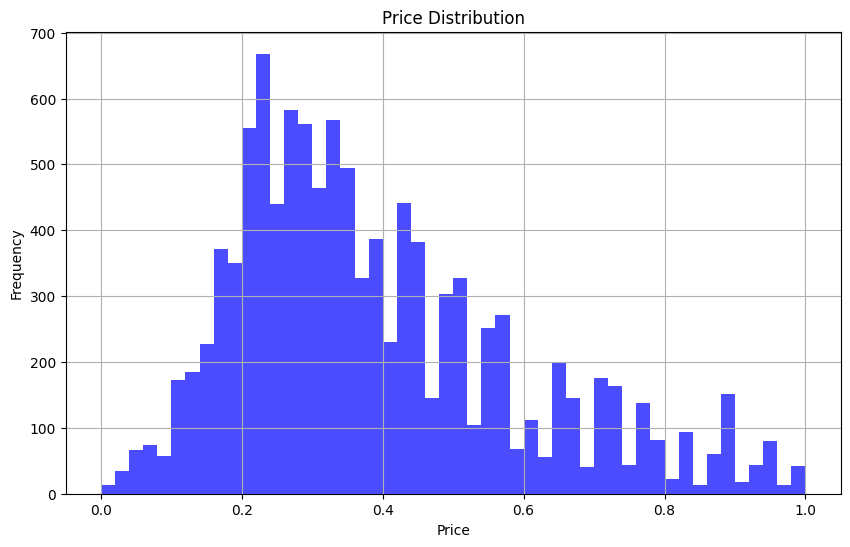

In [17]:
# Describe each attribute using summary statistics
print("Summary Statistics:")
print(data.describe())

# Visualize label distribution
plt.figure(figsize=(10, 6))
plt.hist(data['price'], bins=50, color='blue', alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
# Define RMSE and R-squared functions
def rmse(gt: torch.Tensor, pred: torch.Tensor) -> float:
    # Ensure tensors are on the same device
    if gt.device != pred.device:
        gt = gt.to(pred.device)
    return torch.sqrt(torch.mean((pred - gt).pow(2))).item()

def r2_score(gt: torch.Tensor, pred: torch.Tensor) -> float:
    # Ensure tensors are on the same device
    if gt.device != pred.device:
        gt = gt.to(pred.device)
    ss_res = torch.sum((gt - pred).pow(2))
    ss_tot = torch.sum((gt - torch.mean(gt, dim=1, keepdim=True)).pow(2))
    return (1 - ss_res / ss_tot).item()

In [19]:
def compare_configurations(results):
    # Sort by test R2 score (descending)
    sorted_results = sorted(results, key=lambda x: x['test_r2'], reverse=True)
    
    # Print the table header
    print("\n======= MODEL CONFIGURATIONS RANKED BY TEST R2 SCORE (BEST TO WORST) =======")
    print(f"{'Rank':<5}{'Learning Rate':<15}{'Architecture':<20}{'Activation':<10}{'Optimizer':<15}{'Test R2':<10}{'Test RMSE':<10}{'MSE':<10}")
    print("="*85)
    
    # Print each configuration with its rank
    for i, result in enumerate(sorted_results, 1):
        print(f"{i:<5}{result['lr']:<15}{str(result['arch']):<20}{result['act']:<10}{result['opt']:<15}{result['test_r2']:.4f}{result['test_rmse']:.4f}{result['test_mse']:.4f}")
    
    # Print the best configuration details
    best = sorted_results[0]
    print("\n===== BEST CONFIGURATION =====")
    print(f"Learning Rate: {best['lr']}")
    print(f"Architecture: {best['arch']}")
    print(f"Activation Function: {best['act']}")
    print(f"Optimizer: {best['opt']}")
    print(f"Test R2 Score: {best['test_r2']:.4f}")
    print(f"Test RMSE: {best['test_rmse']:.4f}")
    print(f"Test MSE: {best['test_mse']:.4f}")
    
    return sorted_results

In [20]:
def run_experiments(learning_rates, epochs_list, architectures, activations, optimizers):

    results = []
    
    for lr, epoch, arch, act, opt in product(learning_rates, epochs_list, architectures, activations, optimizers):
        print(f"\nTraining with lr={lr}, epochs={epoch}, arch={arch}, act={act}, opt={opt}")
        nn = NeuralNetwork(device='cuda' if torch.cuda.is_available() else 'cpu')
        input_size = X_train.shape[0]
        output_size = y_train.shape[0]
        device = nn.device
        
        n_samples = X_train.shape[1]
        
        X_val_device = X_val.to(device)
        y_val_device = y_val.to(device)
        X_test_device = X_test.to(device)
        y_test_device = y_test.to(device)
        
        for size in arch:
            nn.add_layer(input_size, size, act)
            input_size = size
        nn.add_layer(input_size, output_size, 'linear')
        
        train_losses = []
        val_losses = []
        
        for i in range(epoch):
            # Train for one epoch and get training loss
            epoch_losses = nn.train(X_train, y_train, epochs=1, batch_size=32 if opt == 'Mini_Batch' else n_samples if opt == 'Batch' else 1, 
                                   learning_rate=lr, loss_function='mse', optimizer=opt, verbose=False)
            train_losses.extend(epoch_losses)
            
            # Calculate validation loss
            with torch.no_grad():
                y_val_pred = nn.predict(X_val_device)
                val_mse = loss(y_val_device, y_val_pred, 'mse').item()
                val_losses.append(val_mse)
        
        # Final evaluation on validation set
        with torch.no_grad():
            y_val_pred = nn.predict(X_val_device)
            val_mse = loss(y_val_device, y_val_pred, 'mse').item()
            val_rmse = rmse(y_val_device, y_val_pred)
            val_r2 = r2_score(y_val_device, y_val_pred)
        
        # Evaluate on test set
        with torch.no_grad():
            y_test_pred = nn.predict(X_test_device)
            test_mse = loss(y_test_device, y_test_pred, 'mse').item()
            test_rmse = rmse(y_test_device, y_test_pred)
            test_r2 = r2_score(y_test_device, y_test_pred)
        
        print(f"Validation Metrics - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}")
        print(f"Test Metrics - MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")
        
        # Plot training and validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Config: lr={lr}, arch={arch}, act={act}, opt={opt}')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.savefig(f'loss_curve_lr{lr}_arch{"_".join(map(str, arch))}_act{act}_opt{opt}.png')
        plt.close()
        
        # Store results
        results.append({
            'lr': lr,
            'arch': arch,
            'act': act,
            'opt': opt,
            'val_mse': val_mse,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'test_mse': test_mse,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'train_losses': train_losses,
            'val_losses': val_losses
        })
    
    return results



Training with lr=0.001, epochs=100, arch=[64, 32], act=relu, opt=Batch
Validation Metrics - MSE: 0.3175, RMSE: 0.5635, R2: -6.5502
Test Metrics - MSE: 0.3230, RMSE: 0.5683, R2: -6.7857


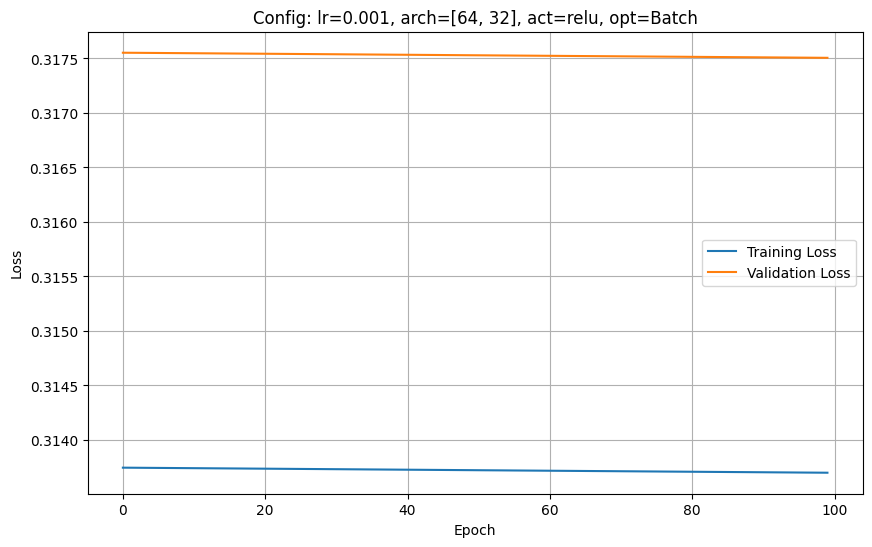


Training with lr=0.001, epochs=100, arch=[64, 32], act=relu, opt=Mini_Batch
Validation Metrics - MSE: 0.0300, RMSE: 0.1731, R2: 0.2872
Test Metrics - MSE: 0.0304, RMSE: 0.1744, R2: 0.2672


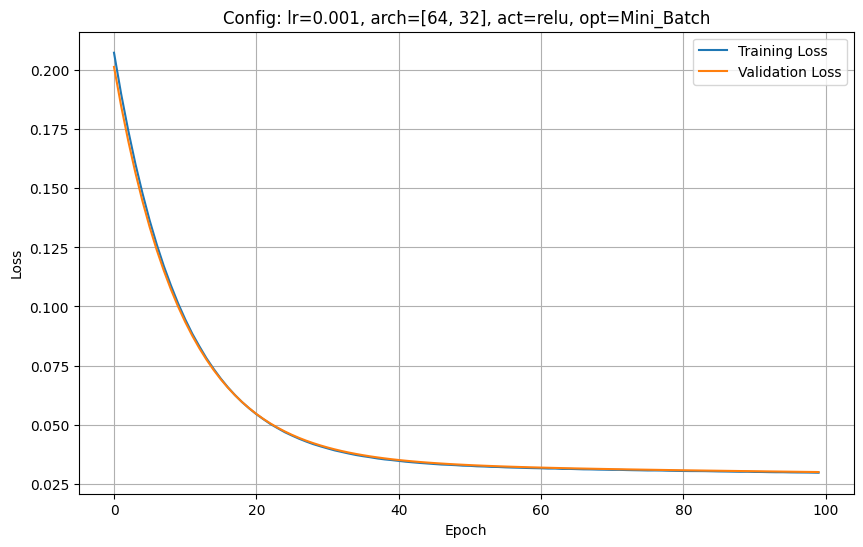


Training with lr=0.001, epochs=100, arch=[64, 32], act=relu, opt=SGD
Validation Metrics - MSE: 0.0171, RMSE: 0.1306, R2: 0.5945
Test Metrics - MSE: 0.0164, RMSE: 0.1280, R2: 0.6050


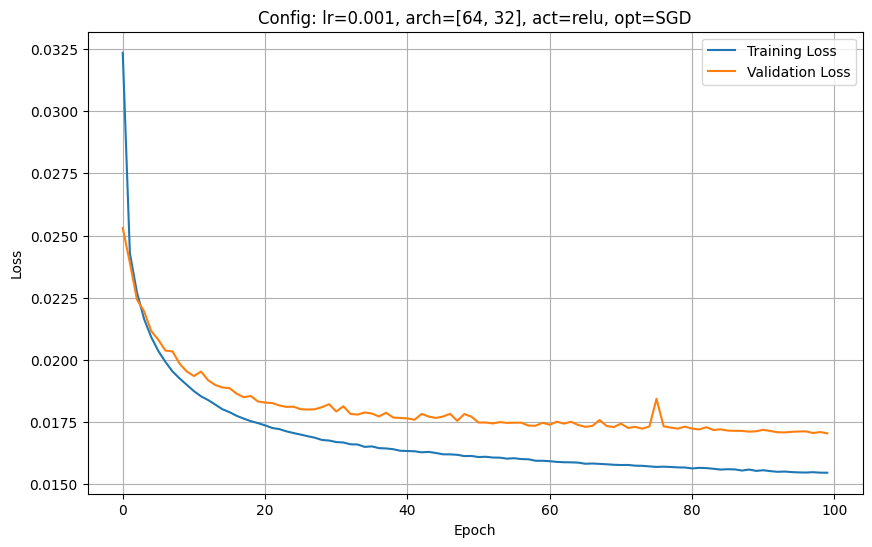


Training with lr=0.001, epochs=100, arch=[64, 32], act=sigmoid, opt=Batch
Validation Metrics - MSE: 0.0454, RMSE: 0.2131, R2: -0.0796
Test Metrics - MSE: 0.0442, RMSE: 0.2102, R2: -0.0650


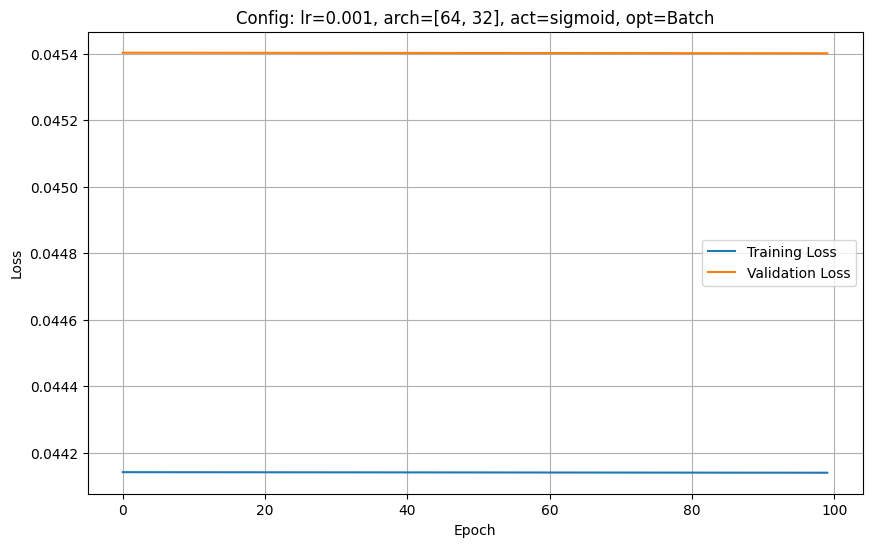


Training with lr=0.001, epochs=100, arch=[64, 32], act=sigmoid, opt=Mini_Batch
Validation Metrics - MSE: 0.0435, RMSE: 0.2086, R2: -0.0344
Test Metrics - MSE: 0.0430, RMSE: 0.2073, R2: -0.0360


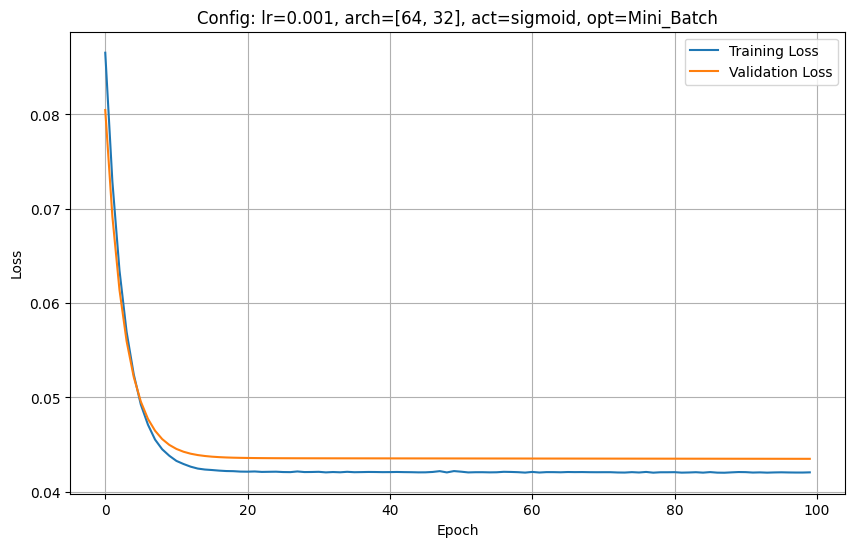


Training with lr=0.001, epochs=100, arch=[64, 32], act=sigmoid, opt=SGD
Validation Metrics - MSE: 0.0199, RMSE: 0.1412, R2: 0.5259
Test Metrics - MSE: 0.0190, RMSE: 0.1379, R2: 0.5418


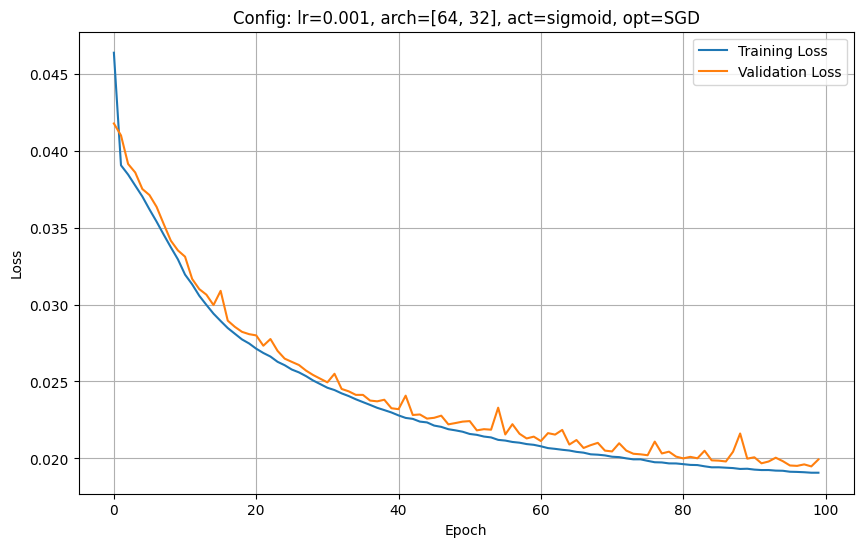


Training with lr=0.001, epochs=100, arch=[64, 32], act=tanh, opt=Batch
Validation Metrics - MSE: 0.3777, RMSE: 0.6146, R2: -7.9818
Test Metrics - MSE: 0.3893, RMSE: 0.6239, R2: -8.3829


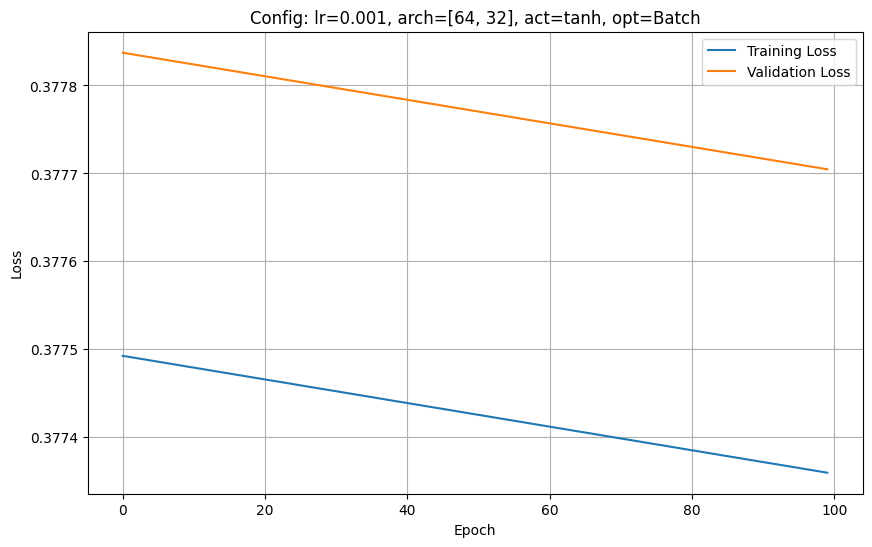


Training with lr=0.001, epochs=100, arch=[64, 32], act=tanh, opt=Mini_Batch
Validation Metrics - MSE: 0.0325, RMSE: 0.1802, R2: 0.2280
Test Metrics - MSE: 0.0330, RMSE: 0.1817, R2: 0.2045


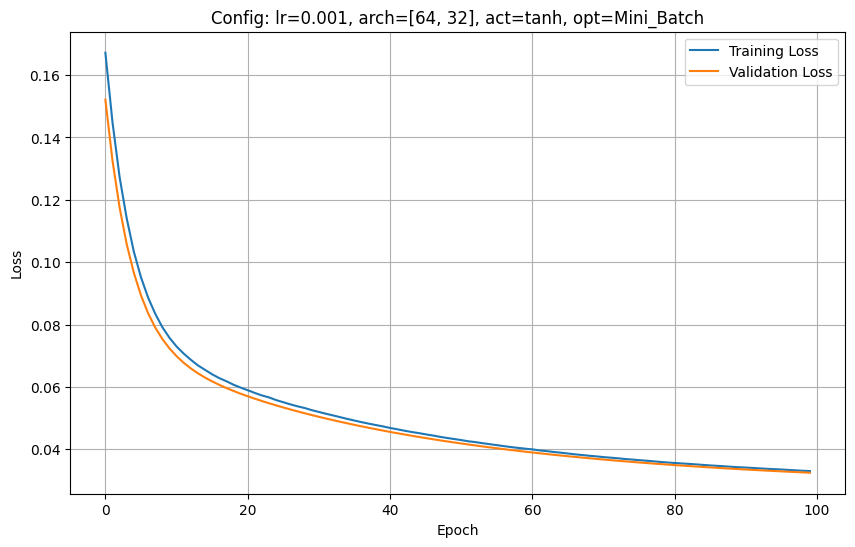


Training with lr=0.001, epochs=100, arch=[64, 32], act=tanh, opt=SGD
Validation Metrics - MSE: 0.0174, RMSE: 0.1318, R2: 0.5867
Test Metrics - MSE: 0.0170, RMSE: 0.1303, R2: 0.5906


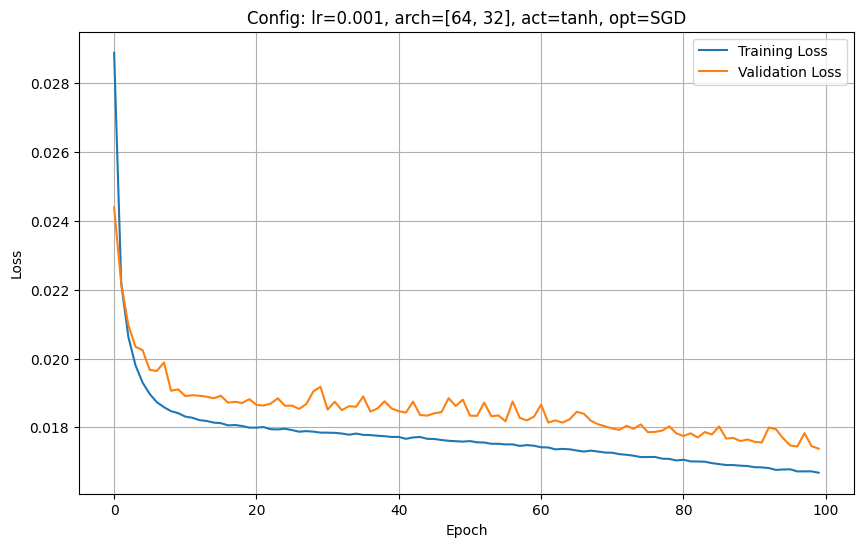


Training with lr=0.001, epochs=100, arch=[128, 64, 32], act=relu, opt=Batch
Validation Metrics - MSE: 0.2239, RMSE: 0.4732, R2: -4.3239
Test Metrics - MSE: 0.2249, RMSE: 0.4743, R2: -4.4219


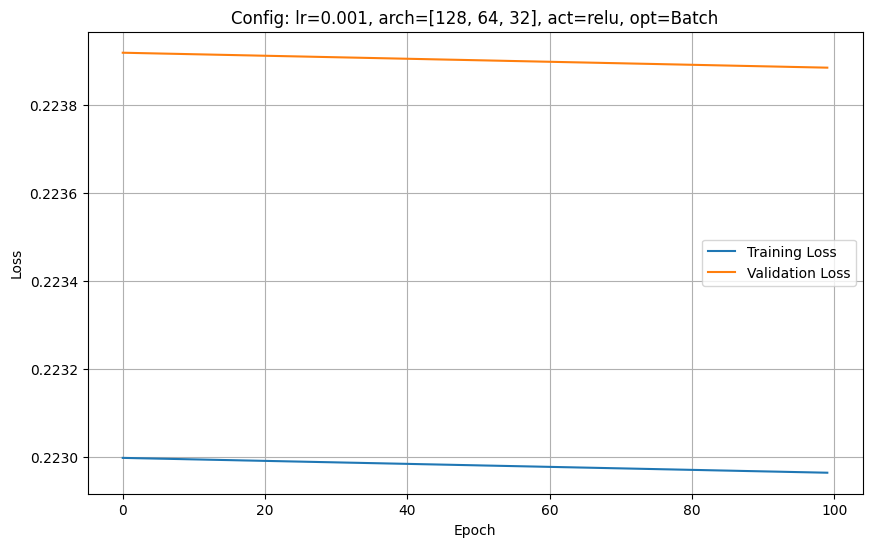


Training with lr=0.001, epochs=100, arch=[128, 64, 32], act=relu, opt=Mini_Batch
Validation Metrics - MSE: 0.0391, RMSE: 0.1978, R2: 0.0699
Test Metrics - MSE: 0.0377, RMSE: 0.1943, R2: 0.0902


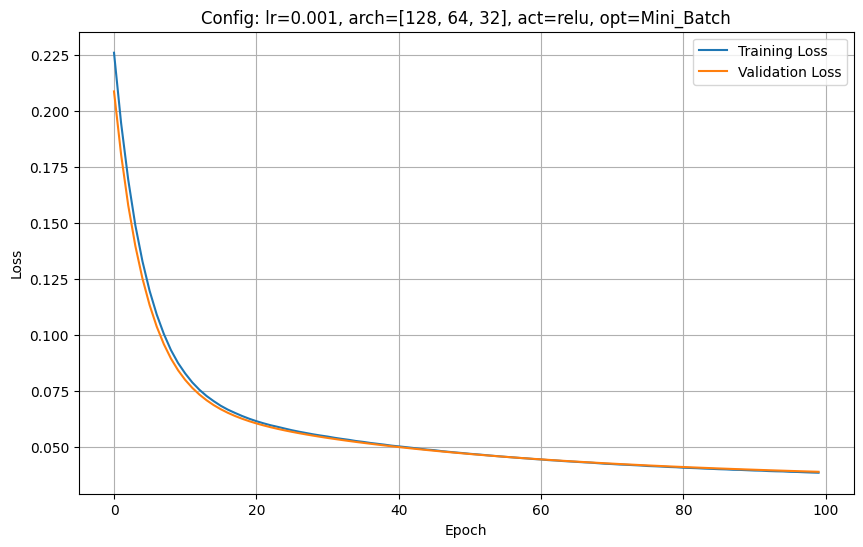


Training with lr=0.001, epochs=100, arch=[128, 64, 32], act=relu, opt=SGD
Validation Metrics - MSE: 0.0175, RMSE: 0.1323, R2: 0.5835
Test Metrics - MSE: 0.0166, RMSE: 0.1290, R2: 0.5989


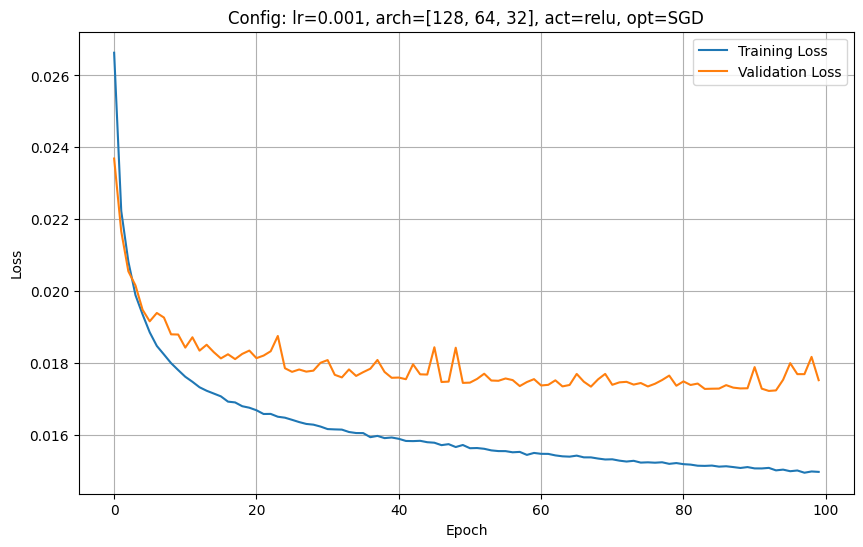


Training with lr=0.001, epochs=100, arch=[128, 64, 32], act=sigmoid, opt=Batch
Validation Metrics - MSE: 0.0424, RMSE: 0.2058, R2: -0.0073
Test Metrics - MSE: 0.0416, RMSE: 0.2041, R2: -0.0039


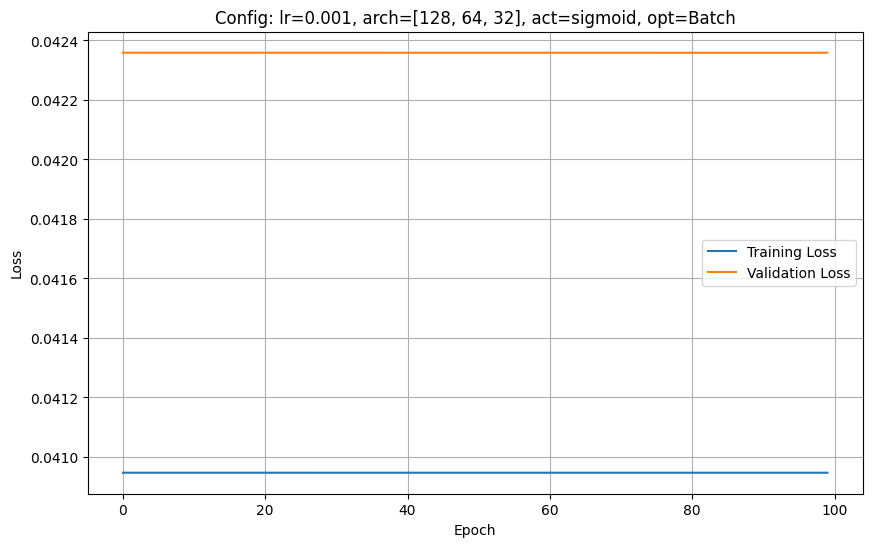


Training with lr=0.001, epochs=100, arch=[128, 64, 32], act=sigmoid, opt=Mini_Batch
Validation Metrics - MSE: 0.0416, RMSE: 0.2040, R2: 0.0100
Test Metrics - MSE: 0.0411, RMSE: 0.2027, R2: 0.0099


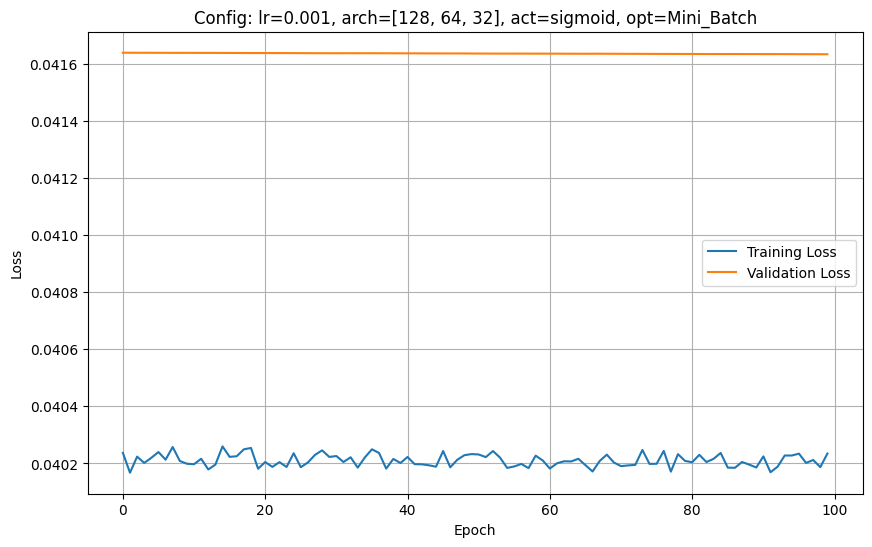


Training with lr=0.001, epochs=100, arch=[128, 64, 32], act=sigmoid, opt=SGD
Validation Metrics - MSE: 0.0214, RMSE: 0.1463, R2: 0.4910
Test Metrics - MSE: 0.0205, RMSE: 0.1432, R2: 0.5060


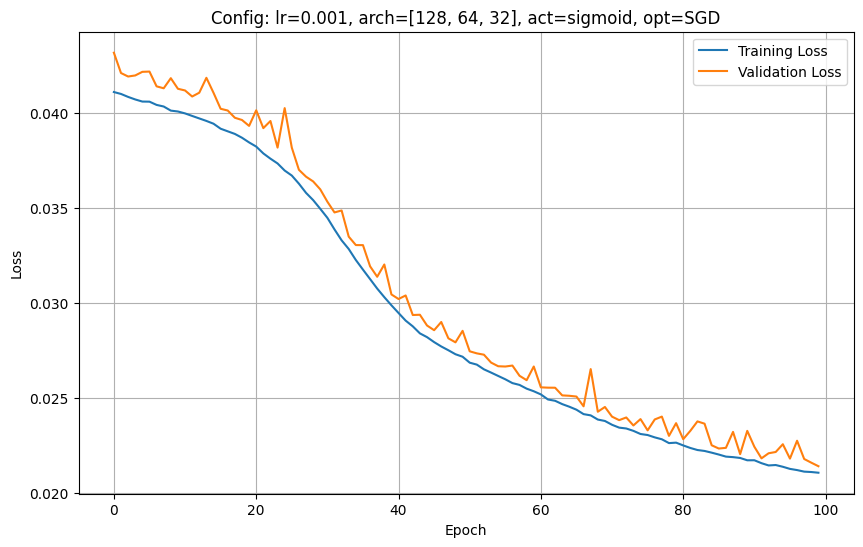


Training with lr=0.001, epochs=100, arch=[128, 64, 32], act=tanh, opt=Batch
Validation Metrics - MSE: 0.0857, RMSE: 0.2928, R2: -1.0384
Test Metrics - MSE: 0.0856, RMSE: 0.2925, R2: -1.0630


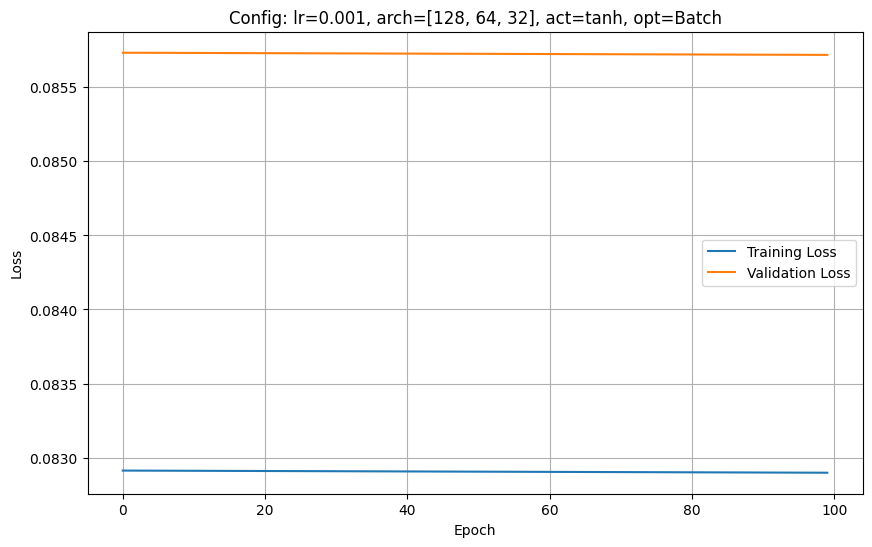


Training with lr=0.001, epochs=100, arch=[128, 64, 32], act=tanh, opt=Mini_Batch
Validation Metrics - MSE: 0.0362, RMSE: 0.1902, R2: 0.1394
Test Metrics - MSE: 0.0351, RMSE: 0.1872, R2: 0.1550


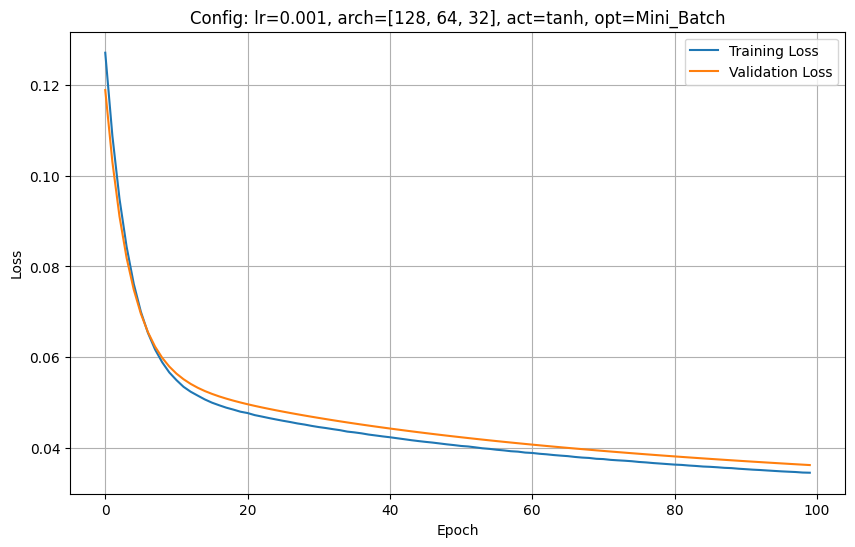


Training with lr=0.001, epochs=100, arch=[128, 64, 32], act=tanh, opt=SGD
Validation Metrics - MSE: 0.0170, RMSE: 0.1302, R2: 0.5969
Test Metrics - MSE: 0.0167, RMSE: 0.1294, R2: 0.5963


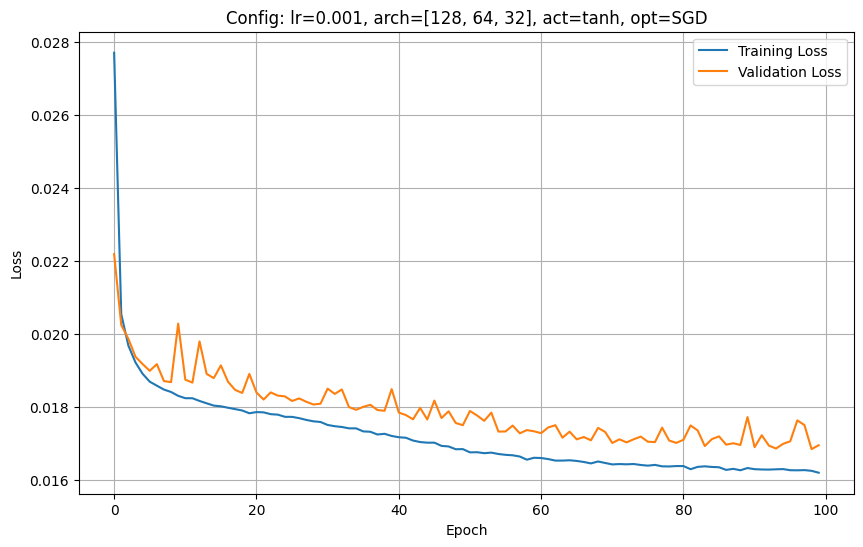


Training with lr=0.01, epochs=100, arch=[64, 32], act=relu, opt=Batch
Validation Metrics - MSE: 0.1868, RMSE: 0.4322, R2: -3.4413
Test Metrics - MSE: 0.1886, RMSE: 0.4343, R2: -3.5458


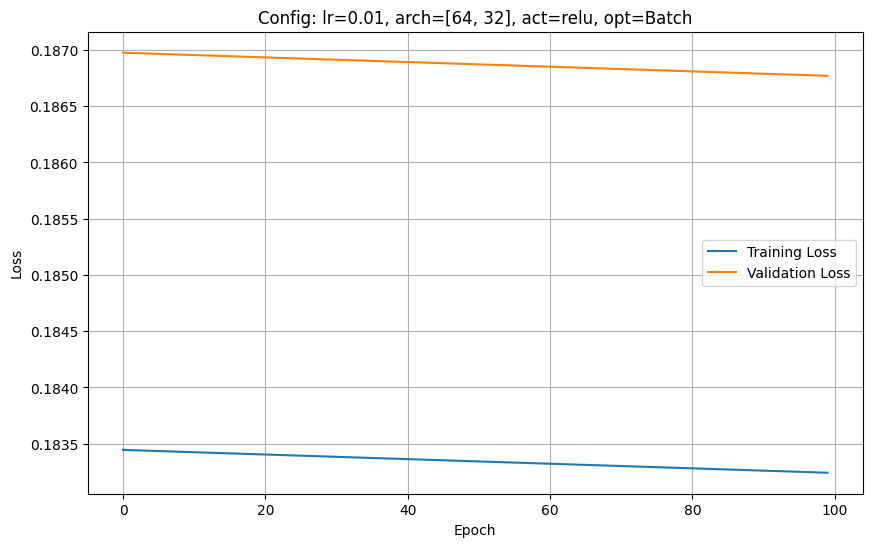


Training with lr=0.01, epochs=100, arch=[64, 32], act=relu, opt=Mini_Batch
Validation Metrics - MSE: 0.0271, RMSE: 0.1645, R2: 0.3567
Test Metrics - MSE: 0.0262, RMSE: 0.1618, R2: 0.3693


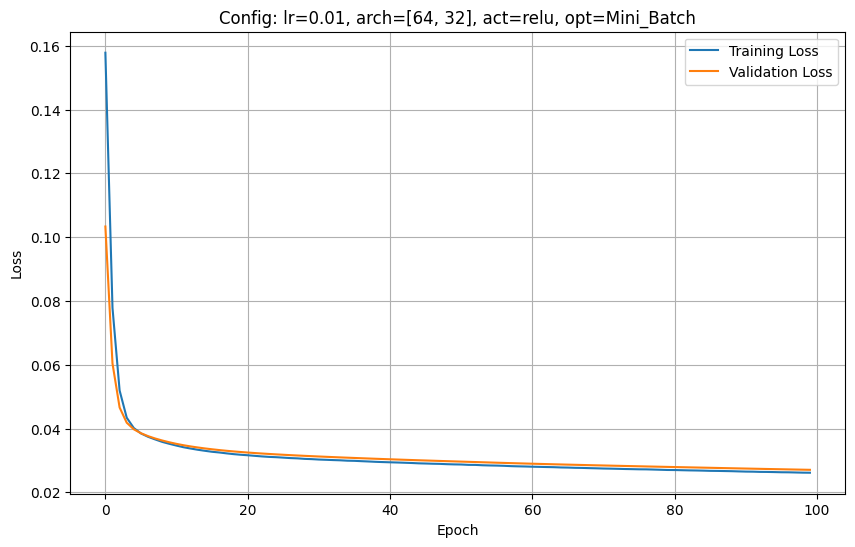


Training with lr=0.01, epochs=100, arch=[64, 32], act=relu, opt=SGD
Validation Metrics - MSE: 0.0170, RMSE: 0.1305, R2: 0.5948
Test Metrics - MSE: 0.0170, RMSE: 0.1305, R2: 0.5893


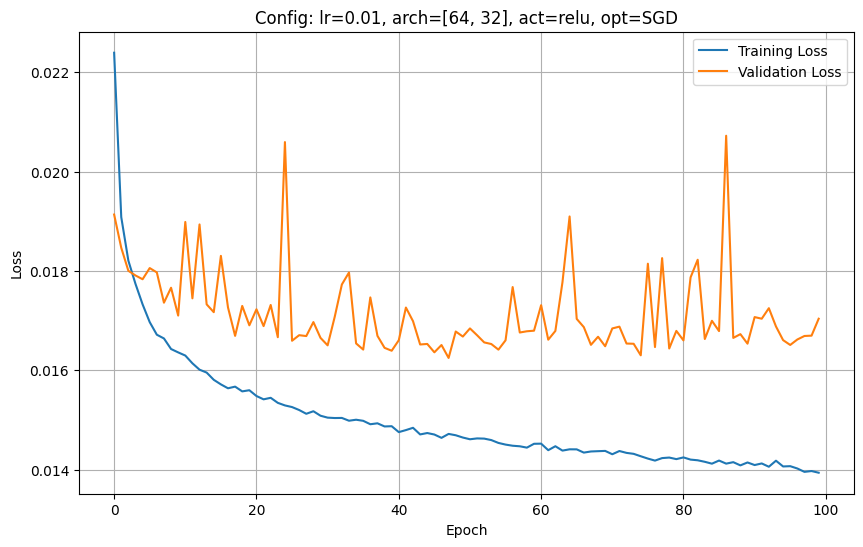


Training with lr=0.01, epochs=100, arch=[64, 32], act=sigmoid, opt=Batch
Validation Metrics - MSE: 0.4592, RMSE: 0.6776, R2: -9.9187
Test Metrics - MSE: 0.4669, RMSE: 0.6833, R2: -10.2555


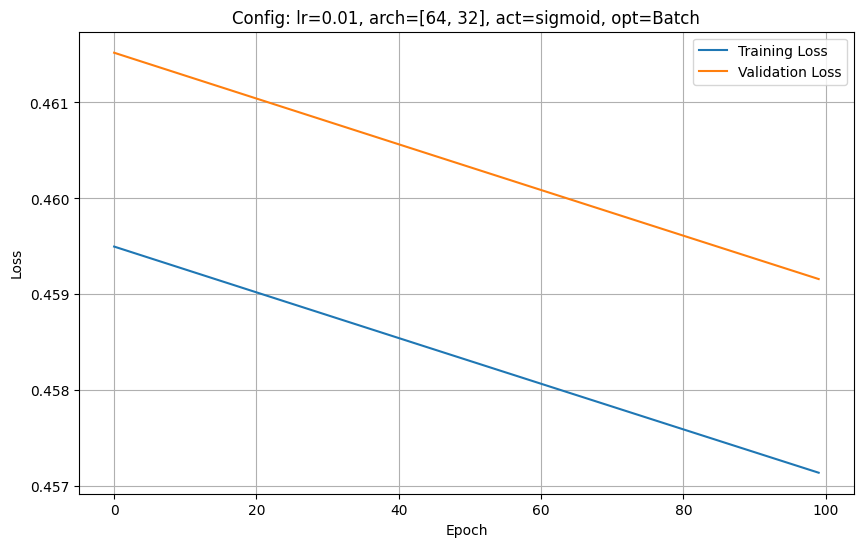


Training with lr=0.01, epochs=100, arch=[64, 32], act=sigmoid, opt=Mini_Batch
Validation Metrics - MSE: 0.0427, RMSE: 0.2066, R2: -0.0155
Test Metrics - MSE: 0.0423, RMSE: 0.2057, R2: -0.0195


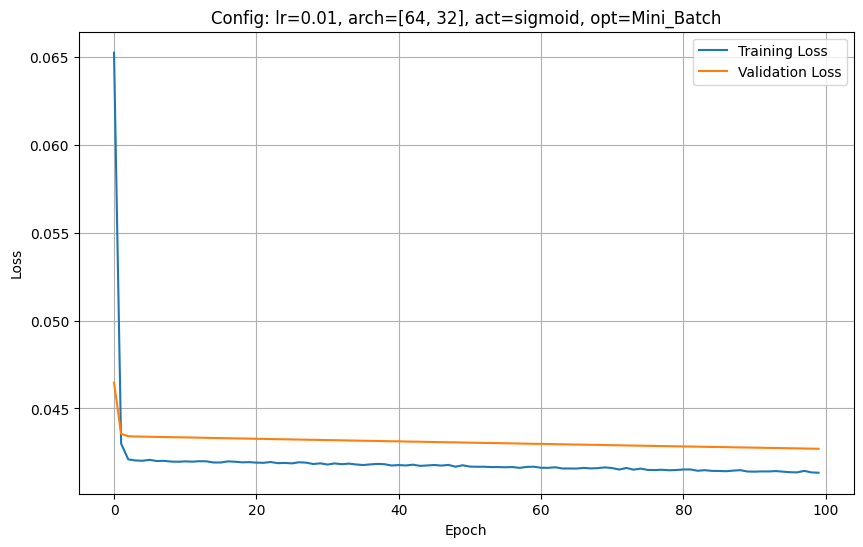


Training with lr=0.01, epochs=100, arch=[64, 32], act=sigmoid, opt=SGD
Validation Metrics - MSE: 0.0185, RMSE: 0.1359, R2: 0.5609
Test Metrics - MSE: 0.0176, RMSE: 0.1328, R2: 0.5746


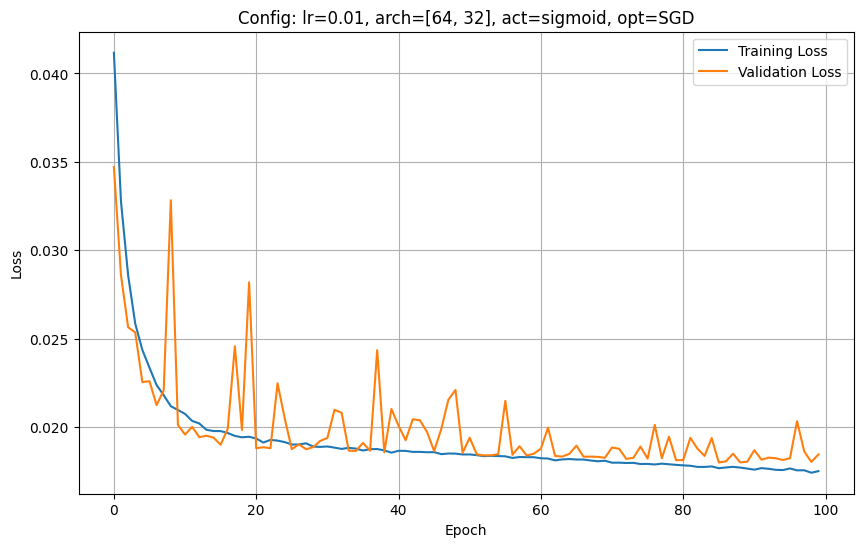


Training with lr=0.01, epochs=100, arch=[64, 32], act=tanh, opt=Batch
Validation Metrics - MSE: 0.1677, RMSE: 0.4095, R2: -2.9871
Test Metrics - MSE: 0.1643, RMSE: 0.4054, R2: -2.9613


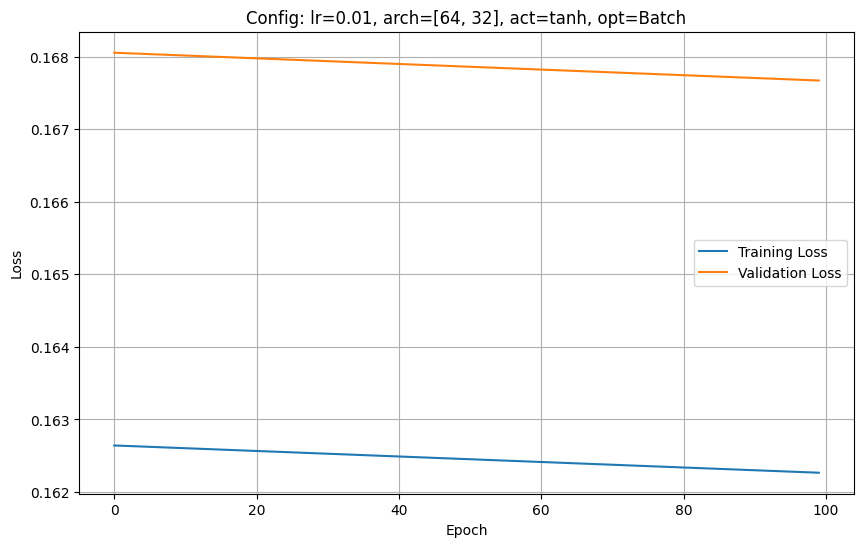


Training with lr=0.01, epochs=100, arch=[64, 32], act=tanh, opt=Mini_Batch
Validation Metrics - MSE: 0.0241, RMSE: 0.1551, R2: 0.4279
Test Metrics - MSE: 0.0232, RMSE: 0.1523, R2: 0.4406


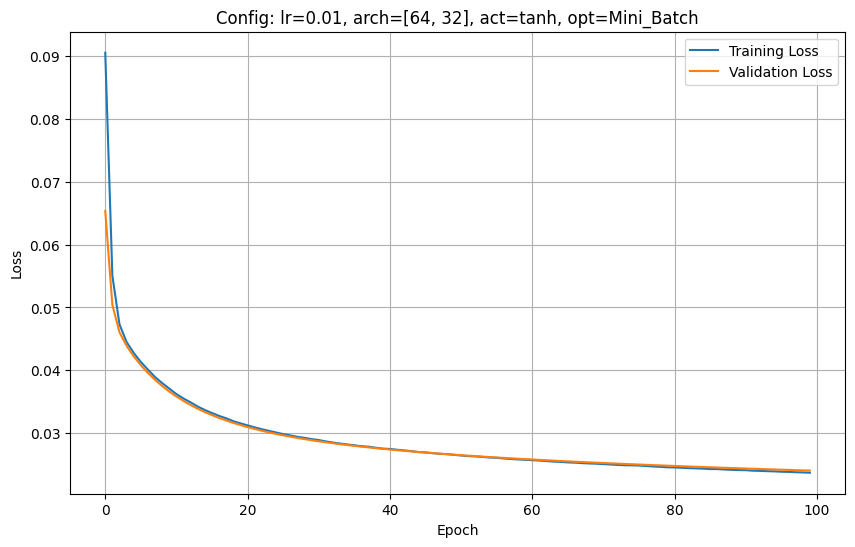


Training with lr=0.01, epochs=100, arch=[64, 32], act=tanh, opt=SGD
Validation Metrics - MSE: 0.0164, RMSE: 0.1280, R2: 0.6106
Test Metrics - MSE: 0.0163, RMSE: 0.1279, R2: 0.6060


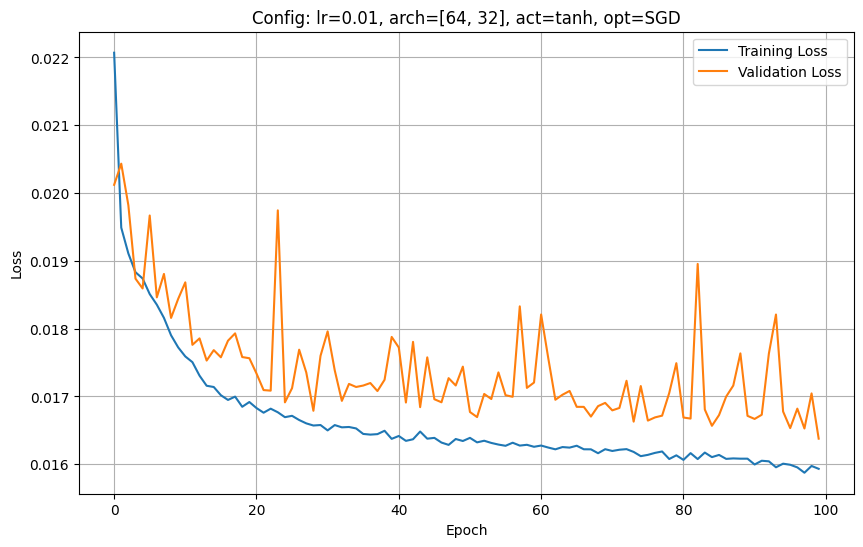


Training with lr=0.01, epochs=100, arch=[128, 64, 32], act=relu, opt=Batch
Validation Metrics - MSE: 0.1355, RMSE: 0.3681, R2: -2.2229
Test Metrics - MSE: 0.1410, RMSE: 0.3755, R2: -2.3983


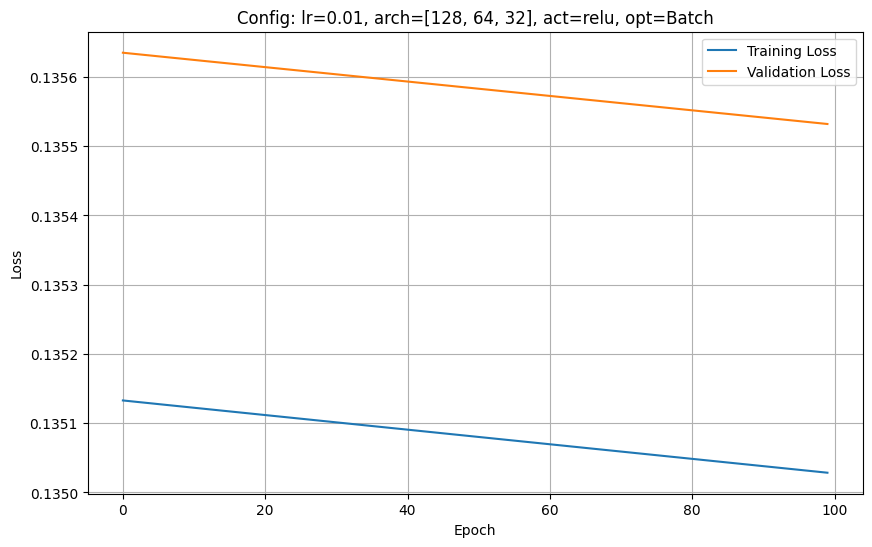


Training with lr=0.01, epochs=100, arch=[128, 64, 32], act=relu, opt=Mini_Batch
Validation Metrics - MSE: 0.0238, RMSE: 0.1541, R2: 0.4351
Test Metrics - MSE: 0.0218, RMSE: 0.1476, R2: 0.4750


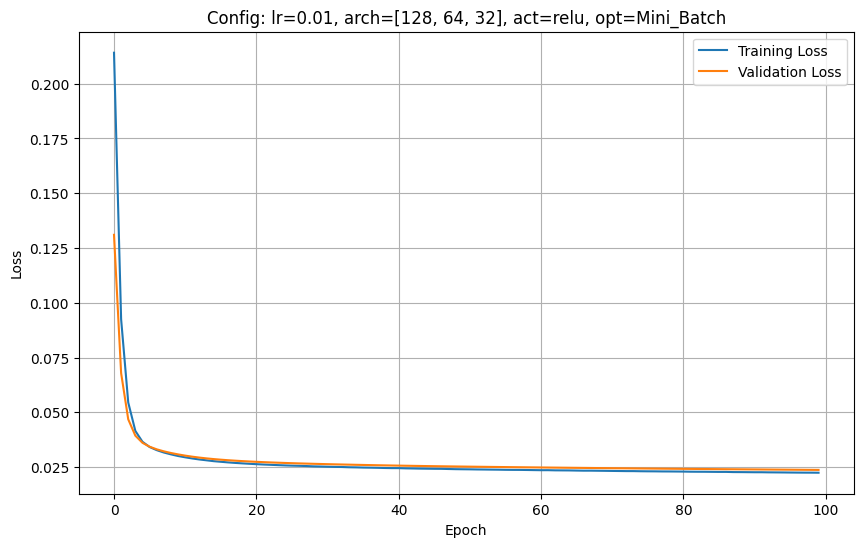


Training with lr=0.01, epochs=100, arch=[128, 64, 32], act=relu, opt=SGD
Validation Metrics - MSE: 0.0184, RMSE: 0.1356, R2: 0.5628
Test Metrics - MSE: 0.0182, RMSE: 0.1348, R2: 0.5622


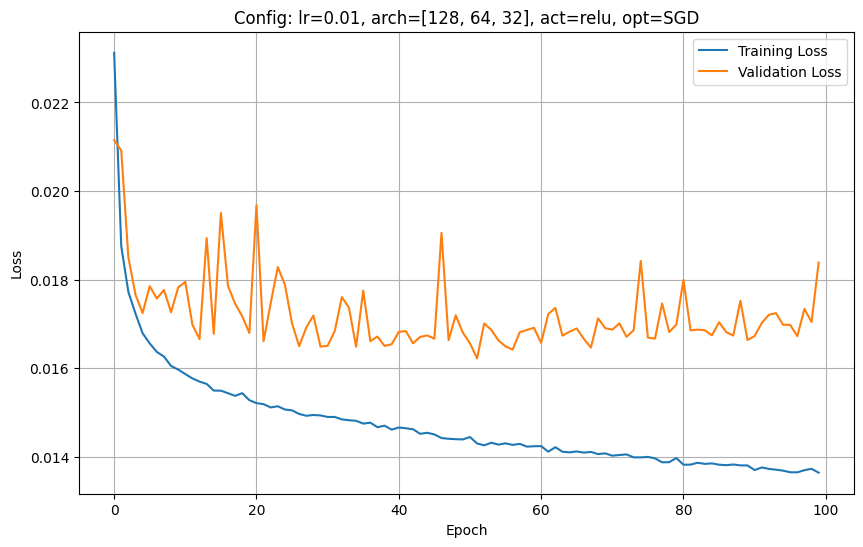


Training with lr=0.01, epochs=100, arch=[128, 64, 32], act=sigmoid, opt=Batch
Validation Metrics - MSE: 0.7719, RMSE: 0.8786, R2: -17.3549
Test Metrics - MSE: 0.7609, RMSE: 0.8723, R2: -17.3415


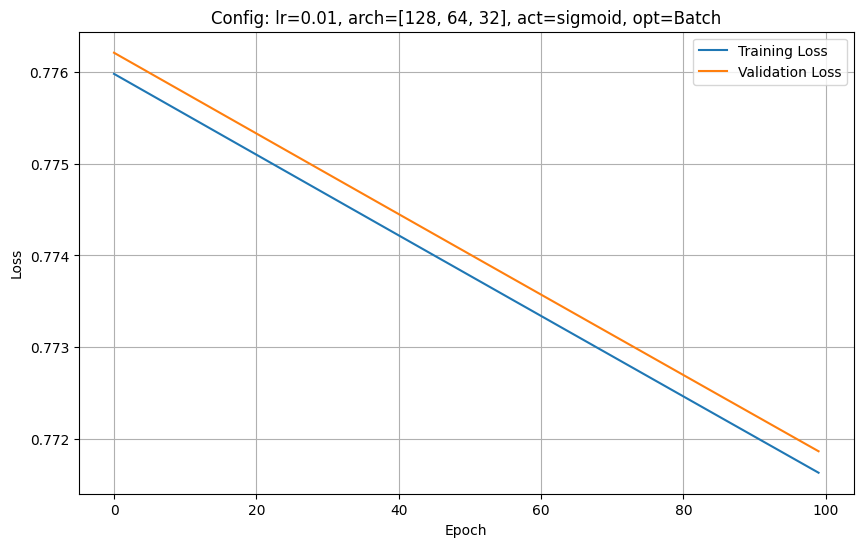


Training with lr=0.01, epochs=100, arch=[128, 64, 32], act=sigmoid, opt=Mini_Batch
Validation Metrics - MSE: 0.0422, RMSE: 0.2053, R2: -0.0024
Test Metrics - MSE: 0.0416, RMSE: 0.2040, R2: -0.0030


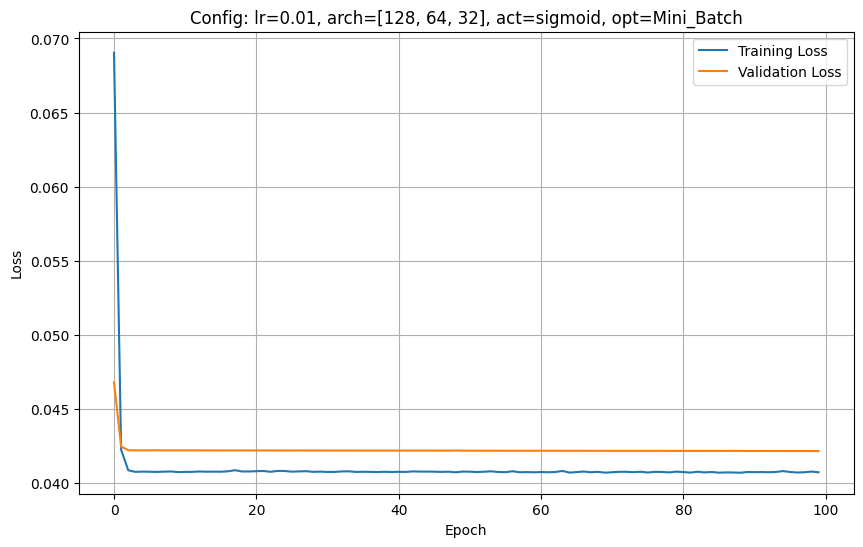


Training with lr=0.01, epochs=100, arch=[128, 64, 32], act=sigmoid, opt=SGD
Validation Metrics - MSE: 0.0183, RMSE: 0.1355, R2: 0.5636
Test Metrics - MSE: 0.0177, RMSE: 0.1329, R2: 0.5744


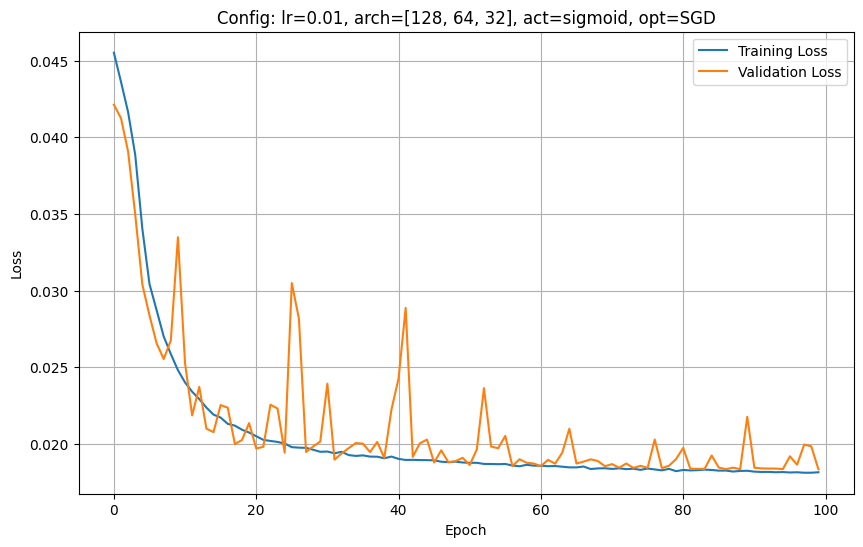


Training with lr=0.01, epochs=100, arch=[128, 64, 32], act=tanh, opt=Batch
Validation Metrics - MSE: 0.1767, RMSE: 0.4203, R2: -3.2015
Test Metrics - MSE: 0.1790, RMSE: 0.4231, R2: -3.3159


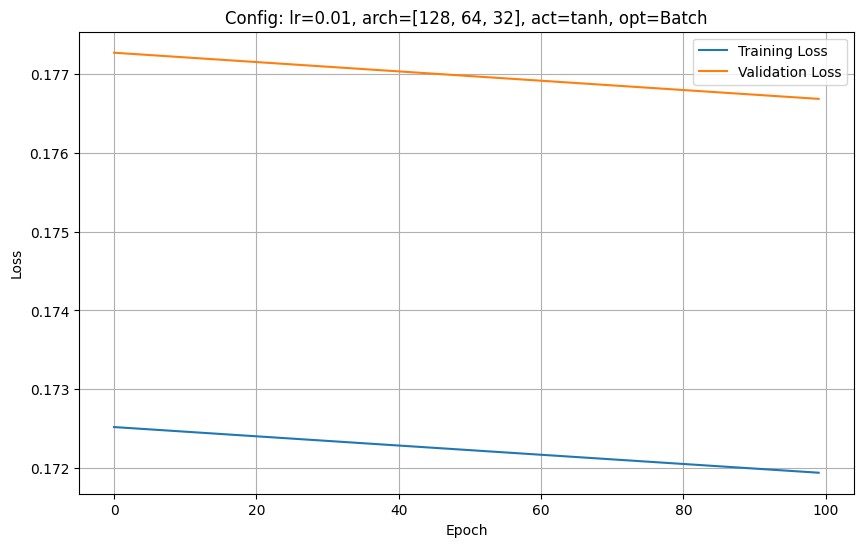


Training with lr=0.01, epochs=100, arch=[128, 64, 32], act=tanh, opt=Mini_Batch
Validation Metrics - MSE: 0.0231, RMSE: 0.1520, R2: 0.4506
Test Metrics - MSE: 0.0223, RMSE: 0.1494, R2: 0.4622


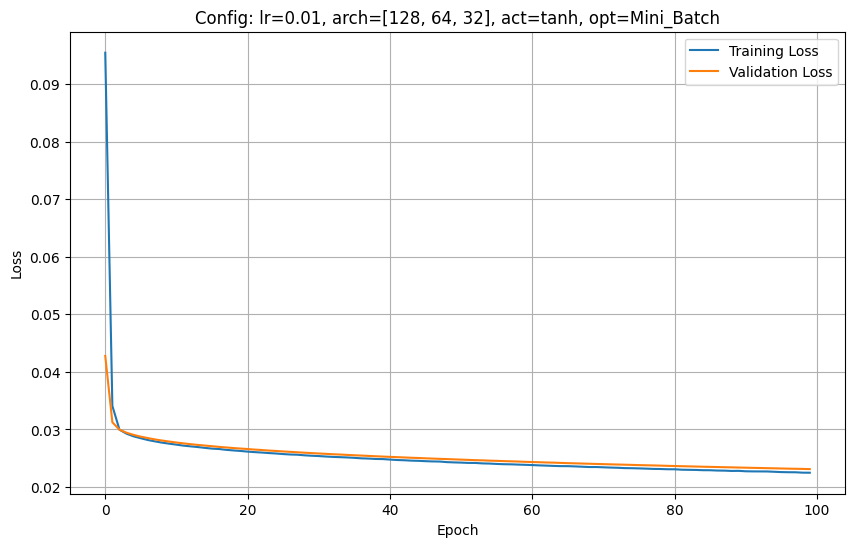


Training with lr=0.01, epochs=100, arch=[128, 64, 32], act=tanh, opt=SGD
Validation Metrics - MSE: 0.0178, RMSE: 0.1333, R2: 0.5776
Test Metrics - MSE: 0.0175, RMSE: 0.1323, R2: 0.5782


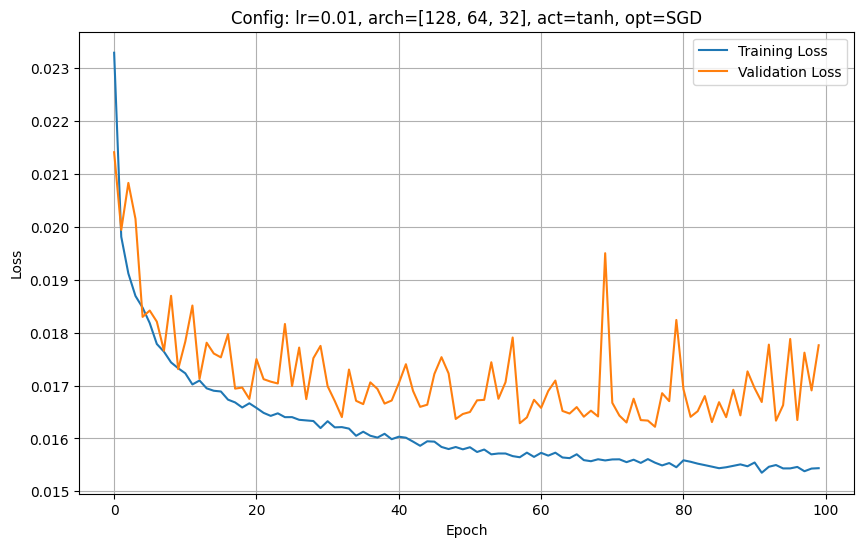


======= MODEL CONFIGURATIONS RANKED BY TEST R2 SCORE (BEST TO WORST) =======
Rank Learning Rate  Architecture        ActivationOptimizer      Test R2   Test RMSE MSE       
1    0.01           [64, 32]            tanh      SGD            0.60600.12790.0163
2    0.001          [64, 32]            relu      SGD            0.60500.12800.0164
3    0.001          [128, 64, 32]       relu      SGD            0.59890.12900.0166
4    0.001          [128, 64, 32]       tanh      SGD            0.59630.12940.0167
5    0.001          [64, 32]            tanh      SGD            0.59060.13030.0170
6    0.01           [64, 32]            relu      SGD            0.58930.13050.0170
7    0.01           [128, 64, 32]       tanh      SGD            0.57820.13230.0175
8    0.01           [64, 32]            sigmoid   SGD            0.57460.13280.0176
9    0.01           [128, 64, 32]       sigmoid   SGD            0.57440.13290.0177
10   0.01           [128, 64, 32]       relu      SGD            0.562

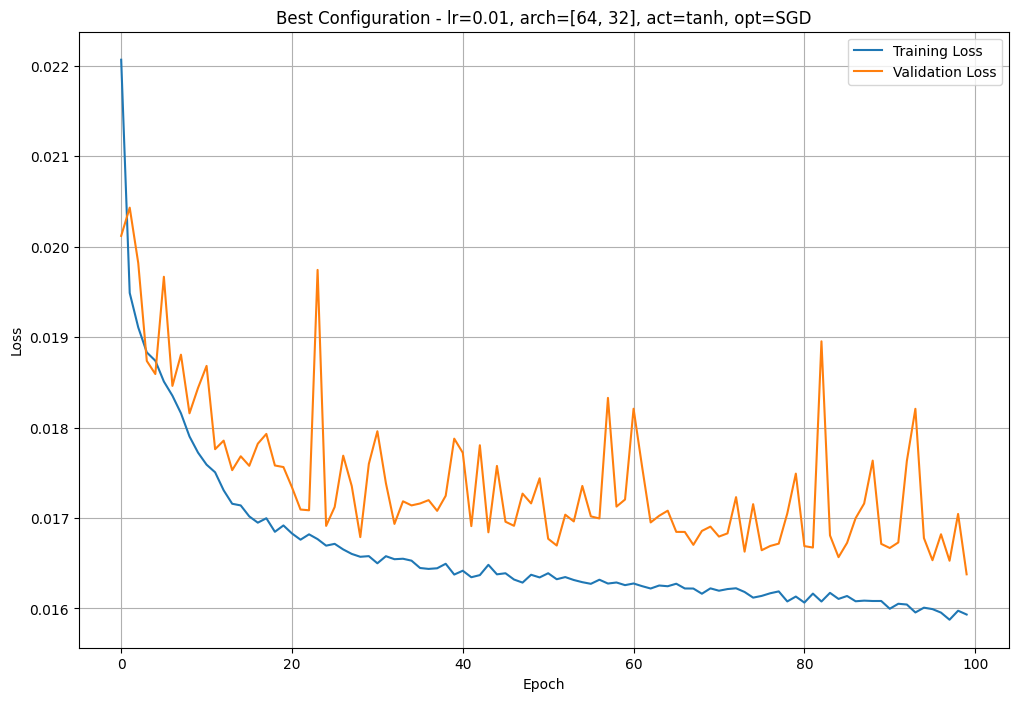


===== EXPERIMENT SUMMARY =====
Total configurations tested: 36
Best configuration: lr=0.01, arch=[64, 32], act=tanh, opt=SGD
Best R2 score: 0.6060


In [21]:
results = run_experiments(learning_rates, epochs_list, architectures, activations, optimizers)

best_config = compare_configurations(results)

# Plot the training curves for the best configuration
best = best_config[0]
plt.figure(figsize=(12, 8))
plt.plot(best['train_losses'], label='Training Loss')
plt.plot(best['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Best Configuration - lr={best["lr"]}, arch={best["arch"]}, act={best["act"]}, opt={best["opt"]}')
plt.legend()
plt.grid(True)
plt.savefig('best_model_loss_curve.png')
plt.show()


print("\n===== EXPERIMENT SUMMARY =====")
print(f"Total configurations tested: {len(results)}")
print(f"Best configuration: lr={best['lr']}, arch={best['arch']}, act={best['act']}, opt={best['opt']}")
print(f"Best R2 score: {best['test_r2']:.4f}") 